In [0]:
# first we have to install some libraries in Colab
!pip install zarr
!pip install gcsfs
!pip install cftime
!apt-get -qq install python-cartopy python3-cartopy

In [0]:
# general setup
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cftime

# set up cartopy
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# notebook display options
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Set Up

In [0]:
# find the SSH data for given choices
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# setup the gcs access
gcs = gcsfs.GCSFileSystem(token='anon')

Choose which model, table, and variables we want to download

In [0]:
#df_ssh = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'zos' & experiment_id == 'ssp245' & institution_id == 'IPSL'")
#df_ssh = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'zos' & institution_id == 'IPSL'")
df_ssh = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & variable_id == 'siconc'")
df_ssh

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
200358,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp119,r1i1p1f1,SImon,siconc,gn,gs://cmip6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp119...,NaN
200426,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp126,r1i1p1f1,SImon,siconc,gn,gs://cmip6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp126...,NaN
200456,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp126,r2i1p1f1,SImon,siconc,gn,gs://cmip6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp126...,NaN
200495,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp245,r1i1p1f1,SImon,siconc,gn,gs://cmip6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp245...,NaN
200525,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp245,r2i1p1f1,SImon,siconc,gn,gs://cmip6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp245...,NaN
...,...,...,...,...,...,...,...,...,...,...
224592,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r3i1p1f1,SImon,siconc,gr,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp...,NaN
224630,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,SImon,siconc,gn,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp...,NaN
224631,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,SImon,siconc,gr,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp...,NaN
224674,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,SImon,siconc,gn,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp...,NaN


Get the datset which we're going to use

In [0]:
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ssh.zstore.values[-1]

# create a mapping interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True, decode_times=False)

Example of information over a map

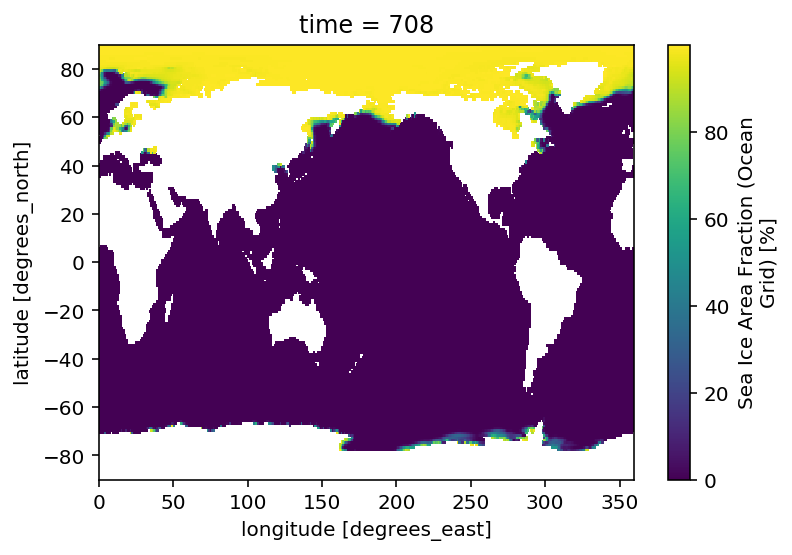

In [0]:
ds.siconc.sel(time=708).squeeze().plot()

Limit the zone information according to requirements

In [0]:
ds_incoor = ds.where( ( 0 < ds.lon ) & (ds.lon < 360) & (60 < ds.lat) & (ds.lat < 90) )

From limited coordinates, print the result

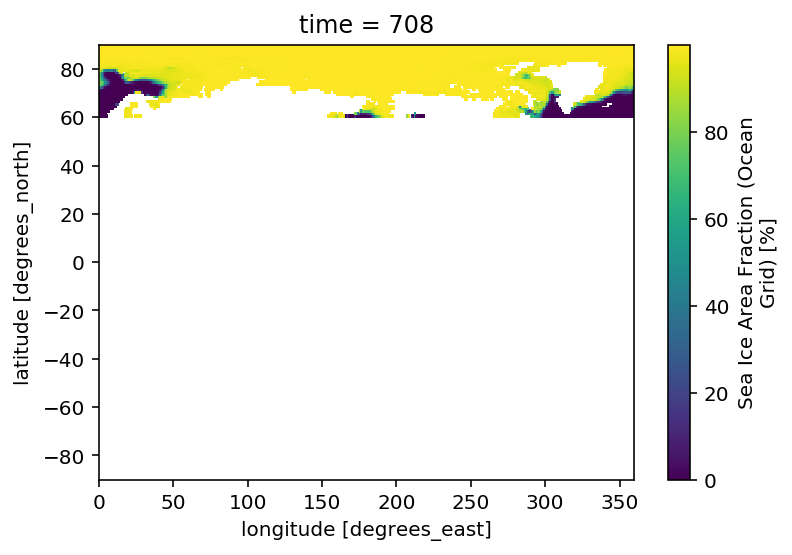

In [0]:
ds_incoor.siconc.sel(time=708).squeeze().plot()

Show the behavior of the "Ocean sea-ice percentage" during the years

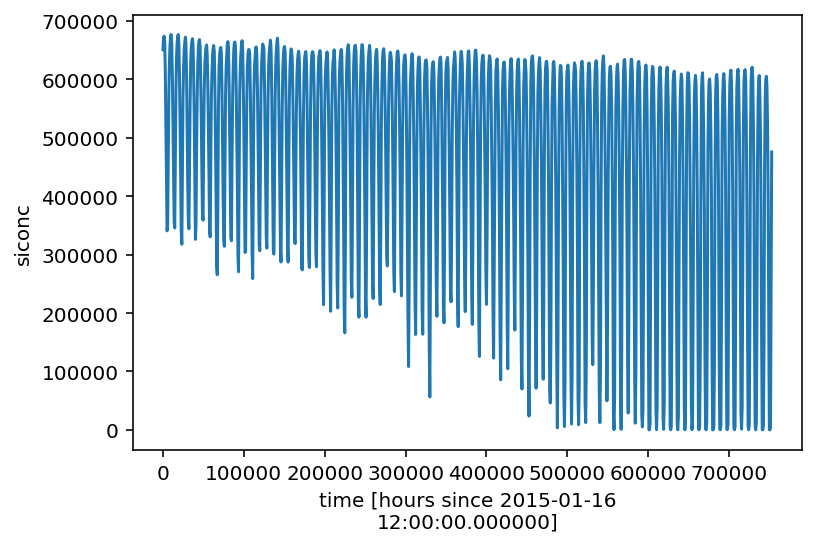

In [0]:
ds_incoor.siconc.mean(dim=['lon', 'lat']).plot()

Get the mean, the standard deviation and plot the behavior with the standard deviation wraping the mean behavior of the ice percentage. Take into account a window of 12 months to determine a "12 month" mean point.

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

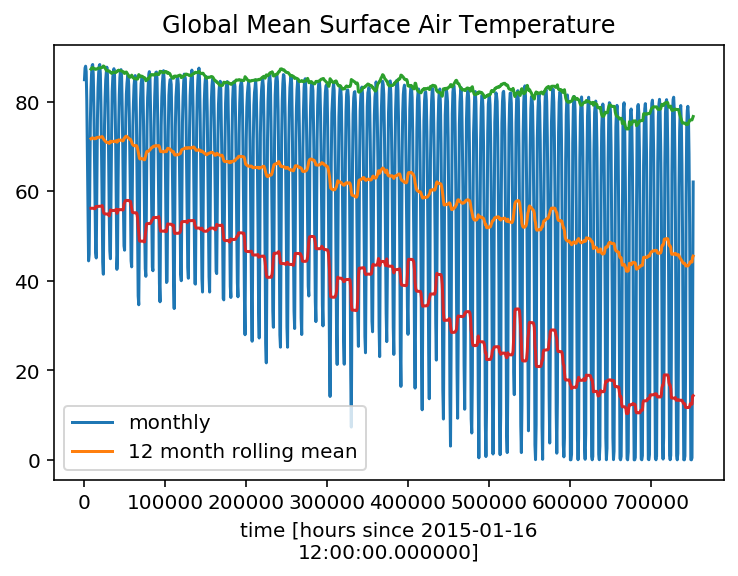

In [0]:
meanv = ds_incoor.siconc.mean(dim=['lon', 'lat'])
meanOfWindow = meanv.rolling(time=12).mean()
stddevOfWindow = meanv.rolling(time=12).std()
v1 = meanOfWindow + stddevOfWindow
v2 = meanOfWindow - stddevOfWindow

meanv.plot(label='monthly')
meanOfWindow.plot(label='12 month rolling mean')
v1.plot()
v2.plot()
plt.legend()
plt.title('Global Mean Surface Air Temperature')

Extract the mean and the standard deviation previously calculated. We confirm the fact that the standard deviation increases in time fo this specifyc model, variable, table and etcetera. Just as an interesting thing to note, the ice-sea percentage has a more "extreme" behavior in this model as time increases. This means that the model is predicting a very low percentage of ice in summer while maintaining aproximately the same quantities in winter, or the inverse, or both cases.

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

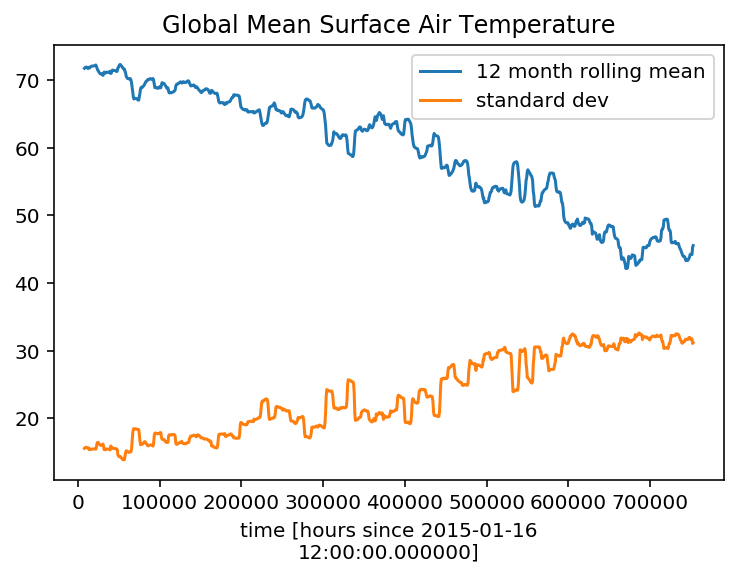

In [0]:
meanOfWindow.plot(label='12 month rolling mean')
stddevOfWindow.plot(label='standard dev')
plt.legend()
plt.title('Global Mean Surface Air Temperature')

In [0]:
# df_area = df.query("variable_id == 'areacello' & source_id == ''")

Transform the datetime information in an actual date since we're receiving as integers. For this case, integers mean hours, so calculations are done to convert them in days and be able to use the pandas tools.

In [0]:
ds_incoor_time = ds_incoor.time.values / 24 + 0.5
ds_incoor_time = pd.to_datetime( ds_incoor_time, unit='D', origin=pd.Timestamp(2015, 1, 16, 12, 0, 0))
ds_incoor_time = ds_incoor_time.to_frame()

ds_incoor = ds_incoor.assign_coords({'time': ds_incoor_time.values.reshape(1032,) })
ds_incoor

Create functions in order to reproduce the previous study on several models / variables / initial_conditions

In [0]:
#
# From a store of available resources, extract the desired resource / model case to study its behavior
#
def getModelInfo(df_store, modelname, model_variable, zstore_index = -1 ) :
  # get the path to a specific zarr store (the first one from the dataframe above)
  df_store = df_ssh [df_ssh[ model_variable ].values == modelname]
  zstore = df_store.zstore.values[ zstore_index ]
  # create a mapping interface to the store
  mapper = gcs.get_mapper(zstore)
  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True, decode_times=False)

  # issue to solve in this if else statements: 
  # the different models and research centers use diverse attributes to express same thing (latitude & longitude), here we catch the cases
  lon_att = None; lat_att = None; 
  if hasattr(ds, 'lon'): lon_att = 'lon'
  elif hasattr(ds, 'longitude'): lon_att = 'longitude'
  elif hasattr(ds, 'nav_lon'): lon_att = 'nav_lon'
  else: raise BaseException(f"no detected lon { ds.coords }")
  if hasattr(ds, 'lat'): lat_att = 'lat'
  elif hasattr(ds, 'latitude'): lat_att = 'latitude'
  elif hasattr(ds, 'nav_lat'): lat_att = 'nav_lat'
  else: raise BaseException(f"no detected lat { ds.coords }")

  lon_lat_cond=( 0 < ds[ lon_att ] ) & (ds[ lon_att ] < 360) & (60 < ds[ lat_att ]) & (ds[ lat_att ] < 90)
  return ds.where( lon_lat_cond )

#
# Extract the mean and standard deviation from the desired model during a windox of X time
#
def getModelMeanAndStdDev(ds_incoor, variable, rolling_time):

  # issue to solve in this if else statements: 
  # the different models and research centers use diverse attributes to express same thing (x & y in a grid), here we catch the cases
  lon = None; lat = None;
  if hasattr(ds_incoor[ variable ], 'x'): lon = 'x'
  elif hasattr(ds_incoor[ variable ], 'nj'): lon = 'nj'
  elif hasattr(ds_incoor[ variable ], 'i'): lon = 'i'
  elif hasattr(ds_incoor[ variable ], 'lon'): lon = 'lon'
  else: raise BaseException(f"no detected lon { ds.coords }")
  if hasattr(ds_incoor[ variable ], 'y'): lat = 'y'
  elif hasattr(ds_incoor[ variable ], 'ni'): lat = 'ni'
  elif hasattr(ds_incoor[ variable ], 'j'): lat = 'j'
  elif hasattr(ds_incoor[ variable ], 'lat'): lat = 'lat'
  else: raise BaseException(f"no detected lat { ds.coords }")
  
  meanv = ds_incoor[ variable ].mean(dim=[lon, lat])
  meanOfWindow = meanv.rolling(time=rolling_time).mean()
  stddevOfWindow = meanv.rolling(time=rolling_time).std()

  return meanOfWindow, stddevOfWindow, meanv

#
# Change integer values on date to timestamps assuming that integrers are expresed in hours
#
def changeDateFromIntHoursToDateTime(ds, length, timestamp_origin):
  ds_time = ds.time.values / 24 + 0.5
  ds_time = pd.to_datetime( ds_time, unit='D', origin=timestamp_origin)
  ds_time = ds_time.to_frame()
  return ds.assign_coords({'time': ds_time.values.reshape(length,) })

# Run Example to test on one possible outcome
df_ssh = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & variable_id == 'siconc' & experiment_id == 'ssp370' & member_id == 'r1i1p1f1' & grid_label == 'gn' ")
ds_incoor = getModelInfo( df_store=df_ssh, modelname = 'IPSL-CM6A-LR' , model_variable = 'source_id',zstore_index = 0)
ds_incoor = changeDateFromIntHoursToDateTime(ds_incoor, 1032, pd.Timestamp(2015, 1, 16, 12, 0, 0))
meanOfWindow, stddevOfWindow, meanv = getModelMeanAndStdDev(ds_incoor, variable='siconc', rolling_time=12)
#ds_incoor.siconc.sel(time=45).squeeze().plot()

Calculate, for different models, but same experiment and initial values, the behavior of the sea-ice percentage. By running this script, we wanted to understand how reliable or how easy was to choose between models. As we can see, models differ, in this case, there is just one that differ highly. We could asssume that the set of models in the top are more reliabe because all of them have a similar output. Instead, the one in the bottom is not very reliable according to this example. So, as a starting point, we would propose a similar approach to chose a model.

Models: 
['CAMS-CSM1-0' 'CanESM5' 'MPI-ESM1-2-HR' 'EC-Earth3-Veg' 'IPSL-CM6A-LR'
 'MIROC6' 'MRI-ESM2-0' 'CESM2-WACCM' 'CESM2' 'GFDL-ESM4']
Institutions: 
['CAMS' 'CCCma' 'DKRZ' 'EC-Earth-Consortium' 'IPSL' 'MIROC' 'MRI' 'NCAR'
 'NOAA-GFDL']


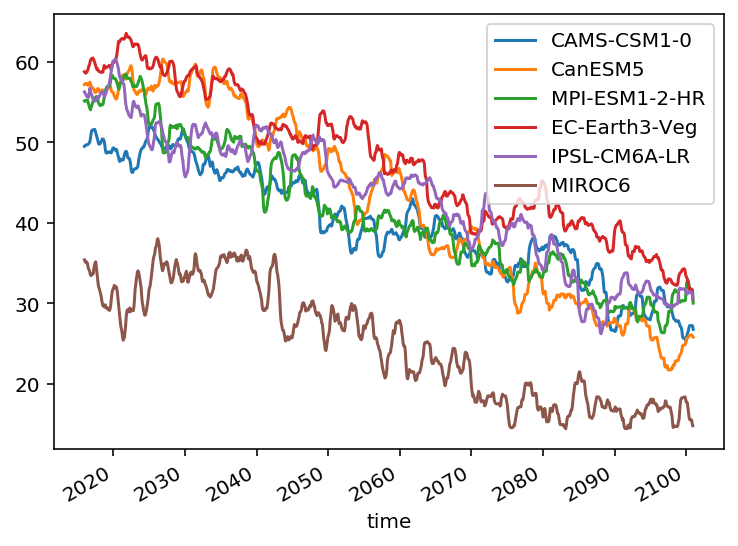

In [0]:
# Get the initial variables = r1i1p1f1, from different models, on same experiment (ssp370)
df_ssh = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & variable_id == 'siconc' & experiment_id == 'ssp370' & member_id == 'r1i1p1f1' & grid_label == 'gn' ")
models = df_ssh.source_id.unique()
#models = models[:4]
print('Models: ')
print(models)
print('Institutions: ')
print(df_ssh.institution_id.unique())
meanOfWindows = []; stddevOfWindows = []
for i, m in enumerate(models):
  if i in [ 0,1,4,5 ]: continue
  ds_incoor = getModelInfo( df_store=df_ssh, modelname = m, model_variable = 'source_id', zstore_index = 0)
  ds_incoor = changeDateFromIntHoursToDateTime(ds_incoor, ds_incoor.sizes['time'], pd.Timestamp(2015, 1, 16, 12, 0, 0))
  mow, stdow, meanv = getModelMeanAndStdDev(ds_incoor, variable='siconc', rolling_time=12)
  meanOfWindows.append(mow)
  stddevOfWindows.append(stdow)

for i, mow in enumerate(meanOfWindows):
  mow.plot(label=models[i])
plt.legend()
plt.show()

In the next case, we will be interested on fixing the type of experiment and the research center by just varying the initial conditions. which, in this case, not differ a lot. So, for this case, we can say that for the grenhouse gaz concentration proposed for the ssp245 (same as these days concentration), all the models predict a decrease of sea-ice concentration, and a final concentration of 40% at the year 2100, so, we're 100% certain of this happening if we kept this institution models.

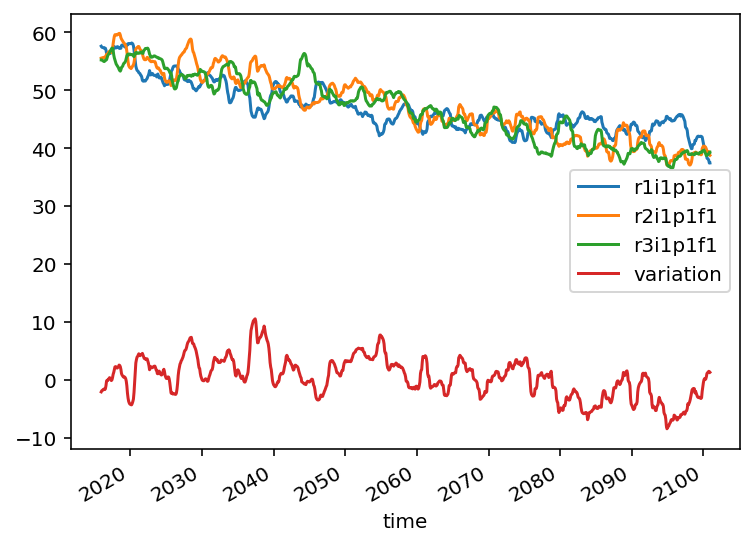

In [0]:
# Get the same model, for the same experiment, play with the different initial conditions
df_ssh = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & source_id == 'CESM2' & variable_id == 'siconc' & experiment_id == 'ssp245' ")
initial_conditions = df_ssh.member_id.unique()
meanOfWindows = []; stddevOfWindows = []
for i, ic in enumerate(initial_conditions):
  ds_incoor = getModelInfo( df_store=df_ssh, modelname = ic, model_variable = 'member_id', zstore_index = 0)
  ds_incoor = changeDateFromIntHoursToDateTime(ds_incoor, ds_incoor.sizes['time'], pd.Timestamp(2015, 1, 16, 12, 0, 0))
  mow, stdow, meanv = getModelMeanAndStdDev(ds_incoor, variable='siconc', rolling_time=12)
  meanOfWindows.append(mow)
  stddevOfWindows.append(stdow)

for i, mow in enumerate(meanOfWindows):
  mow.plot(label=initial_conditions[i])
variation = meanOfWindows[1] - meanOfWindows[0]
variation.plot(label='variation')
plt.legend()
plt.show()

Afterwards, in the next two examples, we fixed the same things as the previous ones (research center, and type of greenhouse gaz concentrations) and vary the initial conditions, but we were curios about changing the gaz concentration to see what models said about the future. In this case, for a concentration of "ssp370" (more than actual concentration), in 100 years, the sea-ice percentage will be reduced to 30%, 100 % less than if we continued with same concentrations. And for the case of "ssp585" (even more concentration), the forecast throws a 10% concentration. 30% less as if we had the same concentrations as nowadays. The most likeley, concentration will increase though, so not good news for our biosphere.

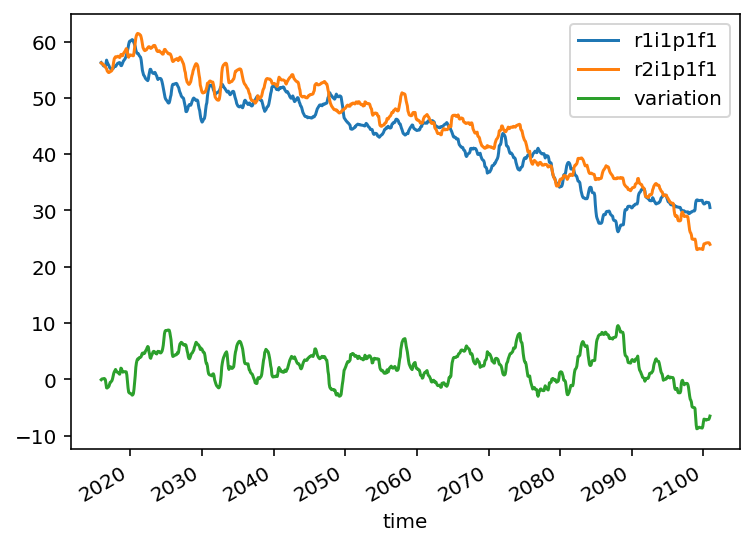

In [0]:
# Get the same model, for the same experiment, play with the different initial conditions
df_ssh = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & source_id == 'CESM2' & variable_id == 'siconc' & experiment_id == 'ssp370' ")
initial_conditions = df_ssh.member_id.unique()
meanOfWindows = []; stddevOfWindows = []
for i, ic in enumerate(initial_conditions):
  ds_incoor = getModelInfo( df_store=df_ssh, modelname = ic, model_variable = 'member_id', zstore_index = 0)
  ds_incoor = changeDateFromIntHoursToDateTime(ds_incoor, ds_incoor.sizes['time'], pd.Timestamp(2015, 1, 16, 12, 0, 0))
  mow, stdow, meanv = getModelMeanAndStdDev(ds_incoor, variable='siconc', rolling_time=12)
  meanOfWindows.append(mow)
  stddevOfWindows.append(stdow)
for i, mow in enumerate(meanOfWindows):
  mow.plot(label=initial_conditions[i])
variation = meanOfWindows[1] - meanOfWindows[0]
variation.plot(label='variation')
plt.legend()
plt.show()

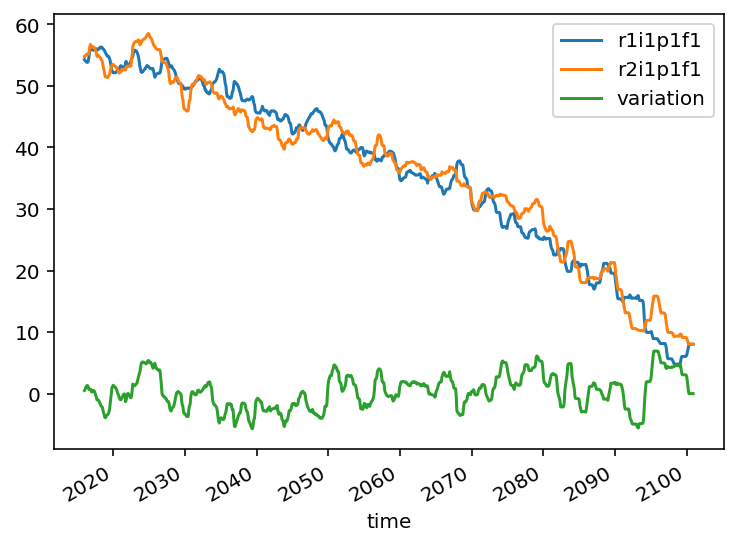

In [0]:
# Get the same model, for the same experiment, play with the different initial conditions
df_ssh = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & source_id == 'CESM2' & variable_id == 'siconc' & experiment_id == 'ssp585' ")
initial_conditions = df_ssh.member_id.unique()
meanOfWindows = []; stddevOfWindows = []
for i, ic in enumerate(initial_conditions):
  ds_incoor = getModelInfo( df_store=df_ssh, modelname = ic, model_variable = 'member_id', zstore_index = 0)
  ds_incoor = changeDateFromIntHoursToDateTime(ds_incoor, ds_incoor.sizes['time'], pd.Timestamp(2015, 1, 16, 12, 0, 0))
  mow, stdow, meanv = getModelMeanAndStdDev(ds_incoor, variable='siconc', rolling_time=12)
  meanOfWindows.append(mow)
  stddevOfWindows.append(stdow)

for i, mow in enumerate(meanOfWindows):
  mow.plot(label=initial_conditions[i])
variation = meanOfWindows[1] - meanOfWindows[0]
variation.plot(label='variation')
plt.legend()
plt.show()